## PGAE for 1D MT inversion
### Created on May 30 2023
### Lian Liu: lianliu1017@126.com

### 1. import modules

In [13]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model, regularizers
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from time import time
import sys
sys.path.append(r'/work/ess-liul/Geophysics/MTPGAE')
from MT1D_fwd import mt1d_analytic, mt1d_analytic_tensor
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### 2. design neural networks

In [57]:
def MT_net(input_size, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel):
    model = models.Sequential()
    model.add(layers.Dense(500, 
                            activation = 'relu', # softplus
                            use_bias = True, 
                            kernel_initializer = tf.constant_initializer(weight_dense1), 
                            bias_initializer = tf.constant_initializer(bias_Dense1), 
                           
                            name = 'dense1', 
                            input_shape = (input_size, )))
    
    # model.add(tf.keras.layers.BatchNormalization())
    # model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(geomodel_size, 
                           # activation = 'relu', 
                           use_bias = True, 
                           kernel_initializer = tf.constant_initializer(weight_geomodel), 
                           bias_initializer = tf.constant_initializer(bias_geomodel), 
                           
                           name = 'geomodel'))

    return model

### 3. run

#### 3.1 prepare data

In [ ]:
def load_field_data(freq, alpha): # Columns: freq, zxy_real, zxy_imag, rhoxy, phsxy, zxye, rhoxye, phsxye # alpha: rho_ANN / rho_real
    rho_field  = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/field/rho_field.txt")
    freq_field = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/field/freq_field.txt")
    num = len(rho_field)
    rho_interp = np.zeros((num, 25))
    
    for i in np.arange(num):
        f1 = interp1d(freq_field, rho_field[i, :], kind = 'linear')
        
        beta = freq[0, 0] / freq_field[0]
        
        freq_trans = freq.reshape(-1) / beta
        
        rho_new = f1(freq_trans)
        
        rho_new = rho_new * alpha
        
        rho_interp[i, :] = rho_new
        
    return rho_interp

In [ ]:
# freq = np.logspace(4, 0, 25).reshape(-1, 1)
# nf_field = 41
alpha = 10 # rho_ANN / rho_real
# rho_interp = load_field_data(freq, alpha)
# print(rho_interp.shape)
# np.savetxt("/work/ess-liul/Geophysics/MTPGAE/field/"+"rho_interp.txt", rho_interp)
rho_interp  = np.loadtxt("/work/ess-liul/Geophysics/MTPGAE/field/rho_interp.txt")

In [268]:
# normalization
rho_linear = np.log10(rho_interp * alpha) / 4.0

#### 3.2 set up network params

In [241]:
geomodel_size = 31 # output size of predict network
input_size = 25

In [ ]:
# load network params
weight_dense1 = np.loadtxt('/work/ess-liul/Geophysics/MTPGAE/ANN/weight_dense1.txt', delimiter = ',')
weight_geomodel = np.loadtxt('/work/ess-liul/Geophysics/MTPGAE/ANN/weight_geomodel.txt', delimiter = ',')
bias_Dense1 = np.loadtxt('/work/ess-liul/Geophysics/MTPGAE/ANN/bias_Dense1.txt', delimiter = ',')
bias_geomodel = np.loadtxt('/work/ess-liul/Geophysics/MTPGAE/ANN/bias_geomodel.txt', delimiter = ',')

#### 3.3 Predicting

In [271]:
model = MT_net(input_size, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel)
model.summary()
start = time()
geomodel_pre = model.predict(rho_linear)
print(time() - start)

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 500)               13000     
                                                                 
 geomodel (Dense)            (None, 31)                15531     
                                                                 
Total params: 28,531
Trainable params: 28,531
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 69ms/step
0.12384867668151855


In [ ]:
# transform
Inverted_rho = 10. ** (geomodel_pre * 4.) / alpha
np.savetxt('/work/ess-liul/Geophysics/MTPGAE/field/Inverted_rho.txt', Inverted_rho)


#### 3.4 plot inverted resistivities

In [275]:
def plot_inverted(geomodel_pre, rho_interp, freq):
    rho_fit = mt1d_analytic_tensor(tf.constant(geomodel_pre.reshape([1, -1])))
    rho_fit = 10. ** (rho_fit.numpy() * 4.) / alpha
    
    # plot
    Inverted_rho = 10. ** (geomodel_pre.reshape(-1) * 4.) / alpha
    dz_invert = 20. + (10.** (0.115 * np.arange(1, len(Inverted_rho) -1, 1))).reshape([1, -1])
    dz_invert = np.hstack([np.array([[20.]]), dz_invert])# / np.sqrt(515./10000.)
    Inverted_rho = np.concatenate([Inverted_rho[0].reshape(-1), Inverted_rho], axis=0)
    
    z_inverted = np.concatenate([[1.], np.cumsum(dz_invert)], axis=0)
    z_inverted = np.append(z_inverted, 10000.)
    
    plt.figure(figsize = (5, 6))
    ####################################plot resistivities####################################
    ax1 = plt.axes([0.20, 0.6, 0.73, 0.38]) # [x, y, width, height]
    ax1.step(z_inverted, Inverted_rho, linewidth = 2., color = 'tab:orange')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    plt.xlim((1e0, 1e4))
    plt.ylim((1e-1, 1e2))
    plt.xlabel('Depth (m)', fontsize = 22)
    plt.ylabel('Resistivity (ohm.m)', fontsize = 22)
    ax1.legend(['Inverted'], loc = 'best', fontsize = 15)
    
    ####################################plot rho####################################
    ax2 = plt.axes([0.20, 0.10, 0.73, 0.38]) # [x,y,width,height]
    ax2.plot(freq, rho_fit.T, linewidth = 2., color = 'tab:orange')
    ax2.plot(freq, rho_interp, linewidth = 2., color = 'tab:blue')
    # ax2.errorbar(freq, rho_field, yerr = rho_sd, fmt = '', ecolor = 'r', color = 'tab:blue', elinewidth = 2, linewidth = 2)
    ax2 = plt.gca()
    ax2.invert_xaxis()
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    plt.xlim((1e3, 1e-2))
    plt.ylim((1e-1, 1e2))
    plt.xlabel('Frequency (Hz)', fontsize = 22)
    plt.ylabel('Rho (ohm.m)', fontsize = 22)
    ax2.legend(['Inverted', 'Real'], loc = 'best', fontsize = 15)
    # plt.savefig('Resis_and_rho.tiff', dpi = 300, format = 'tiff')
    plt.show()

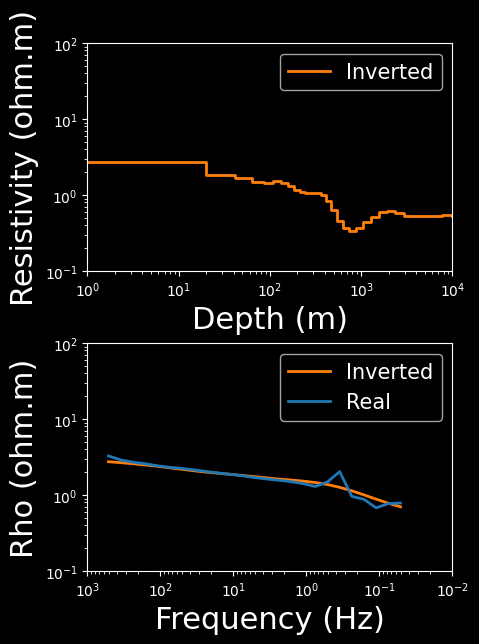

In [289]:
freq = np.logspace(4, 0, 25).reshape(-1, 1)
freq = freq / 10000. * 515.
k = 0
plot_inverted(geomodel_pre[k], rho_interp[k], freq)

### End